<a href="https://colab.research.google.com/github/saivardhan31/saivardhanreddychalla_INFO5731_Spring2022/blob/main/INFO5731_Assignment_Three_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import transformers
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import tensorflow as tf
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment import SentimentAnalyzer
import nltk
from collections import Counter
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, AdaBoostRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import pandas as pd
import time
import pickle
import os


nltk.download('punkt')
nltk.download('wordnet')


warnings.simplefilter(action='ignore', category=FutureWarning)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
!unzip sentiment-analysis-on-movie-reviews.zip
!unzip test.tsv.zip
!unzip train.tsv.zip


Archive:  sentiment-analysis-on-movie-reviews.zip
replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: sampleSubmission.csv    
  inflating: test.tsv.zip            
  inflating: train.tsv.zip           
Archive:  test.tsv.zip
replace test.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: test.tsv                
Archive:  train.tsv.zip
replace train.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: train.tsv               


In [ ]:
df = pd.read_csv("train.tsv", sep='\t', index_col="PhraseId")
pd.set_option('display.max_colwidth', None)
df.head(2)


,SentenceId,Phrase,Sentiment
PhraseId,,,
1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
2,1,A series of escapades demonstrating the adage that what is good for the goose,2


In [ ]:
train, test = train_test_split(
    df[["Phrase", "Sentiment"]].iloc[:11000], random_state=0)
X_train = train.Phrase
X_test = test.Phrase
y_train = train.Sentiment
y_test = test.Sentiment


In [ ]:
def get_accuracy():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    return round(accuracy_score(y_pred, y_test), 3)


# Baseline models
We'll build them through simple steps:

encoding each sentence through basic methods such as bag of words and tf-idf.
using classic trees ensembles that use bagging and boosting, respectively.
ignoring the sentence Id.
ignoring in some cases the less frequent words.

## Random Forest, BOW, TF-IDF

In [ ]:
count_vectorizer = CountVectorizer(max_features=1000)
random_forest = RandomForestClassifier(max_depth=10, n_estimators=10)


In [ ]:
pipe = make_pipeline(count_vectorizer, random_forest)


In [ ]:
get_accuracy()


0.589

Let's look at the percentages of the classes in the true labels and in the predictions.

In [ ]:
y_pred = pipe.predict(X_test)


In [ ]:
round(pd.Series(y_train).value_counts(normalize=True), 2)


2    0.56
3    0.19
1    0.16
4    0.05
0    0.04
Name: Sentiment, dtype: float64

In [ ]:
round(pd.Series(y_pred).value_counts(normalize=True), 2)


2    0.97
3    0.01
1    0.01
0    0.00
4    0.00
dtype: float64

As we can see, Decision Trees in their basic configuration are not a good model for unbalanced data! In almost every node, the biggest category has the majority and that's what the model predicts for almost every row. The accuracy then is aproximately the percentage of the biggest category: 0.5.

Let's add now weights.

In [ ]:
random_forest.set_params(class_weight='balanced')
print(get_accuracy())
random_forest.set_params(class_weight='balanced_subsample')
print(get_accuracy())


0.558
0.525


Surprisingly or not, when using as weights the inverse of the classes proportion, the accuracy gets worst.

Through the confusion matrix we can see that the model is still predicting too much 2, although now the complexity increased.

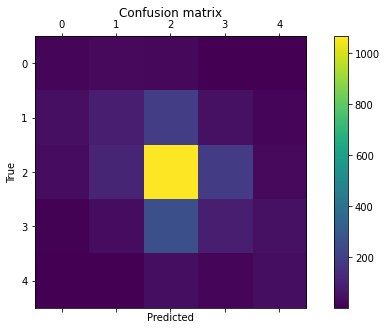

In [ ]:
labels = [i for i in range(5)]
y_pred = pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=labels)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


We'll try also adding lemmatization and replacing the BOW with tf-idf.

In [ ]:
# taken from sklearn webpage
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer


class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]


In [ ]:
pipe[0].set_params(tokenizer=LemmaTokenizer())
get_accuracy()


0.541

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
pipe.steps[0] = ('vectorizer', tfidf_vectorizer)
get_accuracy()


0.536

That is, still poor results. We'll try with boosting.

# Adaboost, chi2

In [ ]:
ada_boost = AdaBoostClassifier()
pipe.steps[1] = ('adaboost', ada_boost)
get_accuracy()


0.597

We now see an improvement. We'll try now using only the most relevant words according to chi2.

In [ ]:
count_vectorizer.get_feature_names


<bound method CountVectorizer.get_feature_names of CountVectorizer(max_features=1000,
                tokenizer=<__main__.LemmaTokenizer object at 0x7fced69d5610>)>

In [ ]:
count_vectorizer = CountVectorizer()

bow = count_vectorizer.fit_transform(X_train)

words = count_vectorizer.get_feature_names()

p_value_limit = 0.95

dtf_features = pd.DataFrame()

for cat in range(5):
    _, p = chi2(bow, y_train == cat)
    dtf_features = dtf_features.append(pd.DataFrame(
        {"feature": words, "score": 1-p, "y": cat}))
    dtf_features = dtf_features.sort_values(["y", "score"],
                                            ascending=[True, False])
    dtf_features = dtf_features[dtf_features["score"] > p_value_limit]

X_names = dtf_features["feature"].unique().tolist()

pipe['vectorizer'].set_params(vocabulary=X_names)

get_accuracy()


0.602

# Neural networks

We'll use a simple NN with only one hidden layer.

In [ ]:
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy',
                     mode='max', verbose=1, save_best_only=True)


In [ ]:
def fit_sequential(X_train, X_test, sequential=None, epochs=20, patience=5):

    if sequential is None:
        input_size = X_train.shape[1]

        sequential = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=(input_size, )),
            tf.keras.layers.Dense(128, activation='sigmoid'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(5)
        ])
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True)
        sequential.compile(optimizer='adam', loss=loss_fn,
                           metrics=['accuracy'])
        global mc
        mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy',
                             mode='max', verbose=1, save_best_only=True)

    es = EarlyStopping(monitor='val_accuracy', mode='max',
                       verbose=1, patience=patience)
    sequential.fit(X_train, np.array(y_train), epochs=epochs, verbose=1,
                   validation_data=(X_test, np.array(y_test)), callbacks=[es, mc])
    sequential.load_weights('best_model.h5')
    return sequential


## Using tf–idf

In [ ]:
vectorizer = TfidfVectorizer()


In [ ]:
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))


In [ ]:
X_train_vectorized = vectorizer.fit_transform(X_train).toarray()
X_test_vectorized = vectorizer.transform(X_test).toarray()


In [ ]:
sequential = fit_sequential(X_train_vectorized, X_test_vectorized)


Epoch 1/20
234/235 [============================>.] - ETA: 0s - loss: 1.2775 - accuracy: 0.5342
Epoch 1: val_accuracy improved from -inf to 0.57600, saving model to best_model.h5
235/235 [==============================] - 4s 13ms/step - loss: 1.2777 - accuracy: 0.5341 - val_loss: 1.1643 - val_accuracy: 0.5760
Epoch 2/20
232/235 [============================>.] - ETA: 0s - loss: 1.1884 - accuracy: 0.5603
Epoch 2: val_accuracy did not improve from 0.57600
235/235 [==============================] - 2s 10ms/step - loss: 1.1879 - accuracy: 0.5607 - val_loss: 1.1378 - val_accuracy: 0.5760
Epoch 3/20
230/235 [============================>.] - ETA: 0s - loss: 1.1487 - accuracy: 0.5625
Epoch 3: val_accuracy did not improve from 0.57600
235/235 [==============================] - 2s 9ms/step - loss: 1.1474 - accuracy: 0.5629 - val_loss: 1.1018 - val_accuracy: 0.5760
Epoch 4/20
232/235 [============================>.] - ETA: 0s - loss: 1.0969 - accuracy: 0.5704
Epoch 4: val_accuracy improved from 

## Using Word2vec

In [ ]:
class W2VTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, size):
        self.size = size
        pass

    def fit(self, X, y=None):
        self.model = Word2Vec(min_count=1,
                              window=2,
                              size=self.size,
                              sample=6e-5,
                              alpha=0.03,
                              min_alpha=0.0007,
                              negative=20)
        sentences = [row.split() for row in X]

        self.model.build_vocab(sentences)
        self.model.train(
            sentences, total_examples=self.model.corpus_count, epochs=self.model.epochs)
        return self

    def get_vector(self, sentence):
        relevant_words_vectors = [self.model.wv[x]
                                  for x in sentence.split() if x in self.model.wv.vocab]
        if not relevant_words_vectors:
            return np.zeros(self.model.vector_size)  # .astype('float32')
        return np.mean(relevant_words_vectors, axis=0)

    def transform(self, X):
        arr = np.array([])
        for elem in X:
            arr = np.concatenate([arr, self.get_vector(elem)])
        return arr.reshape(-1, self.size)


In [ ]:
vectorizer = W2VTransformer(4)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)


In [ ]:
sequential = fit_sequential(X_train_vectorized, X_test_vectorized)


Epoch 1/20
224/235 [===========================>..] - ETA: 0s - loss: 1.2616 - accuracy: 0.5485
Epoch 1: val_accuracy improved from -inf to 0.57600, saving model to best_model.h5
235/235 [==============================] - 1s 3ms/step - loss: 1.2609 - accuracy: 0.5489 - val_loss: 1.1836 - val_accuracy: 0.5760
Epoch 2/20
220/235 [===========================>..] - ETA: 0s - loss: 1.2436 - accuracy: 0.5555
Epoch 2: val_accuracy did not improve from 0.57600
235/235 [==============================] - 1s 3ms/step - loss: 1.2444 - accuracy: 0.5545 - val_loss: 1.1791 - val_accuracy: 0.5760
Epoch 3/20
215/235 [==========================>...] - ETA: 0s - loss: 1.2335 - accuracy: 0.5589
Epoch 3: val_accuracy did not improve from 0.57600
235/235 [==============================] - 1s 3ms/step - loss: 1.2355 - accuracy: 0.5580 - val_loss: 1.1757 - val_accuracy: 0.5760
Epoch 4/20
221/235 [===========================>..] - ETA: 0s - loss: 1.2267 - accuracy: 0.5588
Epoch 4: val_accuracy did not improve 

In [ ]:
pca = PCA(n_components=2)
X_train_vectorized_2d = pca.fit_transform(X_train_vectorized)


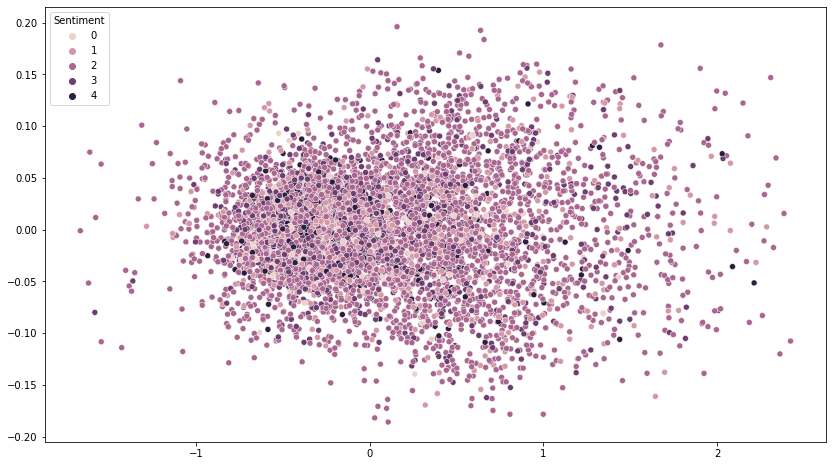

In [ ]:
plt.figure(figsize=(14, 8))
_ = sns.scatterplot(
    X_train_vectorized_2d[:, 0], X_train_vectorized_2d[:, 1], hue=y_train)


Even though the scatterplot is not showing us the "neutral" points we can see that indeed there is not much of a separation between the classes

with the same preprocessing as before but using a neural network, the results are slightly better. It looks like we need to change the preprocessing in such a way that we start using the order between the words. A very first simple method, before we try more complex stuff like Word2Vec or LDA, would be adding 2-grams.

## Using BERT

In [ ]:
model_class, tokenizer_class, pretrained_weights = (
    transformers.DistilBertModel, transformers.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
kaggle_test = pd.read_csv("test.tsv", sep='\t', index_col="PhraseId")

all_sentences = X_train.append([X_test, kaggle_test.Phrase])

tokenized = all_sentences.apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True))

max_len = max(tokenized.apply(len))
padded = np.array([row + [0]*(max_len-len(row)) for row in tokenized])

attention_mask = np.where(padded != 0, 1, 0)

input_ids = torch.tensor(padded)
input_ids = torch.tensor(input_ids).to(torch.int64)

attention_mask = torch.tensor(attention_mask)

vector_length = model(input_ids[:1], attention_mask=attention_mask[:1])[
    0].shape[2]

vectors = np.zeros(shape=(0, vector_length))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


We're using an already trained version of distilBERT. In order to create the embedding, this has to be done in batches. For example through the below function:

In [ ]:
def get_vectors():
    start = time.time()
    k = 1000
    for i in range(0, len(all_sentences), k):
        with torch.no_grad():
            last_hidden_states = model(
                input_ids[i:i+k], attention_mask=input_ids[i:i+k])
        vectors = np.concatenate([vectors, last_hidden_states[0].numpy(
        )[:, 0, :]]) if i > 0 else last_hidden_states[0].numpy()[:, 0, :]
    return vectors


Doing so in a CPU can be highly time consuming (A way of speeding it up could be to use much less precision-numbers). I already saved the data.

In [ ]:
if os.path.isfile("bert_vectors.csv"):
    bert_vectors_df = pd.read_csv("bert_vectors.csv")
    vectors = bert_vectors_df.iloc[:, 1:]
elif os.path.isfile("bert_vectors.pickle"):
    with open('bert_vectors.pickle', 'rb') as handle:
        vectors = pickle.load(handle)
else:
    vectors = get_vectors()
    with open('bert_vectors.pickle', 'wb') as handle:
        pickle.dump(vectors, handle)


In [ ]:
X_train_vectorized = vectors[:len(X_train)]
X_test_vectorized = vectors[len(X_train):len(X_train)+len(X_test)]
kaggle_test_vectorized = vectors[len(X_train)+len(X_test):]


In [ ]:
sequential = fit_sequential(X_train_vectorized, X_test_vectorized, epochs=10)


Epoch 1/10
234/235 [============================>.] - ETA: 0s - loss: 1.2651 - accuracy: 0.5494
Epoch 1: val_accuracy improved from -inf to 0.57600, saving model to best_model.h5
235/235 [==============================] - 1s 4ms/step - loss: 1.2648 - accuracy: 0.5495 - val_loss: 1.1809 - val_accuracy: 0.5760
Epoch 2/10
222/235 [===========================>..] - ETA: 0s - loss: 1.2221 - accuracy: 0.5597
Epoch 2: val_accuracy did not improve from 0.57600
235/235 [==============================] - 1s 4ms/step - loss: 1.2225 - accuracy: 0.5599 - val_loss: 1.1857 - val_accuracy: 0.5760
Epoch 3/10
215/235 [==========================>...] - ETA: 0s - loss: 1.2174 - accuracy: 0.5593
Epoch 3: val_accuracy did not improve from 0.57600
235/235 [==============================] - 1s 3ms/step - loss: 1.2159 - accuracy: 0.5597 - val_loss: 1.1827 - val_accuracy: 0.5760
Epoch 4/10
218/235 [==========================>...] - ETA: 0s - loss: 1.2065 - accuracy: 0.5629
Epoch 4: val_accuracy did not improve 

In [ ]:
vectorizer = W2VTransformer(4)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)
sequential = fit_sequential(X_train_vectorized, X_test_vectorized)
mapper = {0: "negative", 1: "neutral", 2: "positive", 3: "sentiX", 4: "sentiY"}


def get_sentiment(model, vectorizer, mapper, text):
    return mapper.get(np.argmax(max(model.predict(vectorizer.transform(pd.Series([text]))))))


Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


 1/12 [=>............................] - ETA: 4s - loss: 1.0985 - accuracy: 0.4062
Epoch 1: val_accuracy improved from -inf to 0.31200, saving model to best_model.h5
12/12 [==============================] - 1s 20ms/step - loss: 1.0953 - accuracy: 0.3861 - val_loss: 1.1041 - val_accuracy: 0.3120
Epoch 2/20
 1/12 [=>............................] - ETA: 0s - loss: 1.0665 - accuracy: 0.5312
Epoch 2: val_accuracy improved from 0.31200 to 0.34400, saving model to best_model.h5
12/12 [==============================] - 0s 7ms/step - loss: 1.0869 - accuracy: 0.3887 - val_loss: 1.1145 - val_accuracy: 0.3440
Epoch 3/20
 1/12 [=>............................] - ETA: 0s - loss: 1.0765 - accuracy: 0.3125
Epoch 3: val_accuracy did not improve from 0.34400
12/12 [==============================] - 0s 6ms/step - loss: 1.0829 - accuracy: 0.3673 - val_loss: 1.1253 - val_accuracy: 0.3200
Epoch 4/20
 1/12 [=>............................] - ETA: 0s - loss: 1.0734 - accuracy: 0.2812
Epoch 4: val_accuracy impro

In [ ]:
get_sentiment(sequential, vectorizer, mapper, "The new big one is huge")


'positive'

Firstly we are using random forest We build them in simple steps. After loading the CSV file, splitting the data into X train, x_test, y_train and y_test. CountVectorizer function is used to convert the text data into numercial data.
encoding each sentence with simple techniques such as bag of words and tf-idf Traditional tree ensembles with bagging and boosting are used. 

Random Forest and AdaBoost algorithms are both based on the creation of a forest of trees. These are referred to as ensemble learning algorithms. A random forest is created by combining a number of decision trees that use various variables or features and bagging techniques for data sampling. The AdaBoost algorithm is said to make decisions by employing a slew of decision stumps.

AdaBoost is a machine learning algorithm that may be used to improve the performance of any other machine learning technique. It works well with students who are struggling. Decision trees with one level are the most suitable and hence most commonly used algorithm with AdaBoost.

While coming to the other models TfIdf,  Word2Vec and BERT we are using neural network to which we are passing vector input and flattening it an then we are adding a dense layer with 128 logits and then using dropout layer and then we are adding a dense layer with softmax activation and logits equal to number of classes